In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta 
import os
import os, glob

# Define hydrological flood extraction function

In [34]:
def flood_extract(id, thresh_value, time_lag, path_id, path_out):
    
###  load df
    df = pd.read_csv(path_id)

### convert date to posixct format
    df['Datetime']=pd.to_datetime(df['Datetime'], format="%Y-%m-%d")

### extract date details
    df["day"] = df['Datetime'].map(lambda x: x.day)
    df["month"] = df['Datetime'].map(lambda x: x.month)
    df["year"] = df['Datetime'].map(lambda x: x.year)

### remove 29.02
    drop=list(df[(df['day'] ==29) & (df['month'] ==2)].index)
    df=df.drop(drop)
    df=df.reset_index(drop=True)
    
### determine threshold: annual maxima series
    AMS = df.resample('Y', on='Datetime').max() 
    thr= np.nanquantile(AMS['streamflow(mm/d)'],thresh_value)
    thr=np.full(365, thr)
    converter= lambda x: x.timetuple().tm_yday
    
### create column in table with corresponding thresholds
    df['threshold']=np.tile(thr,len(df.year.unique()))[:df.shape[0]]
    
### identify above threshold values

    flood_ids=np.where(df['streamflow(mm/d)'] > df['threshold'])[0].tolist()
    flood_datetime=df[df.index.isin(np.where(df['streamflow(mm/d)'] 
                                             > df['threshold'])[0].tolist())].Datetime
    flood_flow=df['streamflow(mm/d)'][df['streamflow(mm/d)'].index.isin
                                      (np.where(df['streamflow(mm/d)'] 
                                                > df['threshold'])[0].tolist())]
    pot=pd.DataFrame(
        {'Datetime':flood_datetime,
        'flow':flood_flow})
    pot['Datetime']=pd.to_datetime(pot['Datetime'], format="%Y-%m-%d")
    pot['timestamp']=pd.to_datetime(pot['Datetime'], format="%Y-%m")
    pot.reset_index(inplace=True)
                                                
                                                                                          
### compute flood event characteristics
    end=np.where(np.array([x - flood_ids[i - 1] for i, x in enumerate(flood_ids)][1:]) >1)[0]
    start=end+1
    start=np.insert(start, 0,0)
    end=np.insert(end,len(end),(len(flood_ids)-1))
    start_ids=[flood_ids[index] for index in start]
    end_ids=[flood_ids[index] for index in end]

    duration = []
    volume = []
    start_date = []
    end_date = []
    peak_discharge=[]
    date=[]

    for e in range(len(start_ids)):
        duration.append((end[e] - start[e])+1)
        start_date.append(df.Datetime[start_ids[e]])
        end_date.append(df.Datetime[end_ids[e]]) 
        startend_id = np.arange(start_ids[e],end_ids[e]+1)
        volume.append((pot.loc[pot["index"].isin(startend_id),'flow']
                       -df["threshold"][start_ids[e]]).sum())
        peak_discharge.append(max(pot.loc[pot["index"].isin(startend_id),'flow']))
        date.append(pot.Datetime[pot.loc[pot["index"].isin(startend_id),'flow'].idxmax()])        
  
    event_df=pd.DataFrame(
        {'start_date':start_date,
         'end_date':end_date,
         'duration': duration,
         'volume': volume,
         'peak_discharge': peak_discharge,
         'date_peak':date
        })
    
### remove dependent events
### if an event is not separated by the prescribed time lag, remove the smallers in terms of duration
    event_df['delta_bet_events'] = event_df['start_date'] - event_df.shift(periods=1)['end_date']
    event_df['delta_boolean'] = event_df['delta_bet_events']<timedelta(days=time_lag)
    event_df['changing_boolean'] = event_df['delta_boolean'].diff()
    
    ids = [None]
    for i, row in event_df.iterrows():
        if row['delta_boolean']:
            priorPeak = event_df.loc[i-1, 'peak_discharge']
            priorPeak_id = i-1
        
            ids.append(i)
        
            if (row['peak_discharge'] > BiggerPeak) & (row['peak_discharge'] > priorPeak):
            # print('ID_b:',BiggerPeak_id,'\tpeak_discharge_b:', BiggerPeak)
                BiggerPeak = row['peak_discharge']
                BiggerPeak_id = i
            # print('ID:',BiggerPeak_id,'\tpeak_discharge:', BiggerPeak)

            elif (priorPeak >= BiggerPeak) & (priorPeak >= row['peak_discharge']):
                BiggerPeak = priorPeak
                BiggerPeak_id = priorPeak_id
    
        elif (row['delta_boolean']==False) and (len(ids)==1):
        
            ids = [i]

            BiggerPeak, BiggerPeak_id = 0, 0
    
        elif (row['delta_boolean']==False) and (len(ids)>1):
        # print(ids, 'fechou')
        # print(longestDuration_id, longestDuration)

            drop_ids = ids
            drop_ids.remove(BiggerPeak_id)
            # drop_ids = ids.pop(longestDuration_id)
            # print(drop_ids)
            # print()


            event_df.drop(drop_ids, inplace=True)

            ids = [i]
            BiggerPeak, BiggerPeak_id = 0, 0
    
### save
    event_df=event_df.drop(columns=['delta_bet_events','delta_boolean', 'changing_boolean'])
    path_to_save=os.path.join(path_out,"Cabra_"+str(id)+"_th"+str(thresh_value)+"_tl"+str(time_lag))
    event_df.to_csv(path_to_save+".csv", sep=',',index=False) 

## load data and apply

In [65]:
path_id = os.listdir('database_mm/')
path_out= ''
path_att = pd.read_csv(f'/CABra_attibutes_att.csv', sep=',', index_col= 'id')

In [1]:
for i in path_id:
    id=int(i.split("_")[1])
    path=os.path.join('database_mm/',i)
    zeros= path_att.loc[{id},'% of zeros']
    if float(zeros)<=0.05:
        flood_extract(id, 0.10, 7, path, path_out)
        print("feito com sucesso:",i)
    else:
        print(i, "is ephemeral")

In [17]:
df_test = pd.read_csv('C:/Users/User/Downloads/Cabra/Data/database_mm/CABra_18_mmd.csv')

In [18]:
  ### convert date to posixct format
df_test['Datetime']=pd.to_datetime(df_test['Datetime'], format="%Y-%m-%d")

  ### extract date details
df_test["day"] = df_test['Datetime'].map(lambda x: x.day)
df_test["month"] = df_test['Datetime'].map(lambda x: x.month)
df_test["year"] = df_test['Datetime'].map(lambda x: x.year)

  ### remove 29.02
drop=list(df_test[(df_test['day'] ==29) & (df_test['month'] ==2)].index)
df_test=df_test.drop(drop)
df_test=df_test.reset_index(drop=True)
    
   ### determine threshold: annual maxima series
AMS= df_test.resample('Y', on='Datetime').max()
thr_num = np.nanquantile(AMS['streamflow(mm/d)'] ,0.15)
thr=np.full(365, thr_num)
df_test['threshold']=np.tile(thr,len(df_test.year.unique()))[:df_test.shape[0]]

In [19]:
thr_num

1.888586566096423e-06

In [20]:
flood_ids=np.where(df_test['streamflow(mm/d)'] > df_test['threshold'])[0].tolist()
flood_datetime=df_test[df_test.index.isin(np.where(df_test['streamflow(mm/d)'] > df_test['threshold'])[0].tolist())].Datetime
flood_flow=df_test['streamflow(mm/d)'][df_test['streamflow(mm/d)'].index.isin(np.where(df_test['streamflow(mm/d)'] > df_test['threshold'])[0].tolist())]
pot=pd.DataFrame({'Datetime':flood_datetime,
        'flow':flood_flow})
pot['Datetime']=pd.to_datetime(pot['Datetime'], format="%Y-%m-%d")
pot.reset_index(inplace=True)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

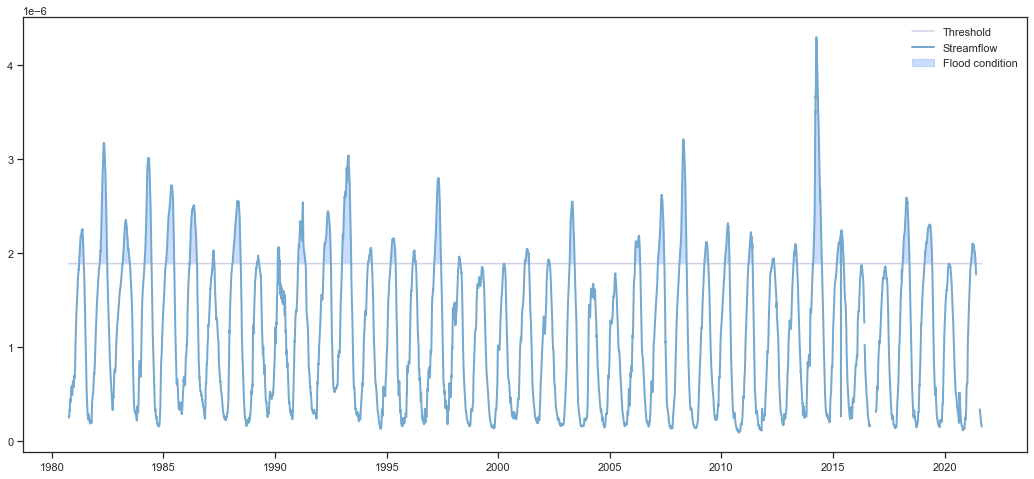

In [68]:
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(18, 8))

# Plot lines
ax.plot(df_test['Datetime'],df_test['threshold'], color="#D0D1E6", label='Threshold')
ax.plot(df_test['Datetime'],df_test['streamflow(mm/d)'], color= "#74A9CF", linewidth=2, label="Streamflow")

ax.fill_between(
    df_test['Datetime'],df_test['streamflow(mm/d)'],df_test['threshold'], 
    where=(df_test['streamflow(mm/d)'] >= df_test['threshold']),
    interpolate=True, color="#5490FF", alpha=0.3,
    label="Flood condition",
);
plt.rcParams['font.size']='20'
ax.legend(frameon=False)

plt.savefig("id18_flood.png", dpi=400)

In [22]:
### compute flood event characteristics
 
end=np.where(np.array([x - flood_ids[i - 1] for i, x in enumerate(flood_ids)][1:]) >1)[0]
start=end+1
start=np.insert(start, 0,0)
end=np.insert(end,len(end),(len(flood_ids)-1))
start_ids=[flood_ids[index] for index in start]
end_ids=[flood_ids[index] for index in end]

In [23]:
duration = []
volume = []
start_date = []
end_date = []
peak_discharge=[]
date=[]

for e in range(len(start_ids)):
    duration.append((end[e] - start[e])+1)
    start_date.append(df_test.Datetime[start_ids[e]])
    end_date.append(df_test.Datetime[end_ids[e]]) 
    startend_id = np.arange(start_ids[e],end_ids[e]+1)
    volume.append((pot.loc[pot["index"].isin(startend_id),'flow']
                   -df_test["threshold"][start_ids[e]]).sum())
    peak_discharge.append(max(pot.loc[pot["index"].isin(startend_id),'flow']))
    date.append(pot.Datetime[pot.loc[pot["index"].isin(startend_id),'flow'].idxmax()])
    
    
event_df=pd.DataFrame(
    {'start_date':start_date,
        'end_date':end_date,
         'duration': duration,
        'volume': volume,
         'peak_discharge': peak_discharge,
         'date_peak':date
    })


In [8]:
event_df

,start_date,end_date,duration,volume,peak_discharge,date_peak
0,1981-01-24,1981-01-27,4,1.586591e-06,0.000002,1981-01-26
1,1981-03-28,1981-03-29,2,5.492866e-07,0.000002,1981-03-29
2,1981-03-31,1981-04-07,8,1.003652e-05,0.000004,1981-04-04
3,1982-01-16,1982-01-16,1,2.492484e-08,0.000002,1982-01-16
4,1982-01-20,1982-01-20,1,1.302420e-08,0.000002,1982-01-20
...,...,...,...,...,...,...
112,2020-04-09,2020-04-11,3,5.724000e-07,0.000002,2020-04-10
113,2020-04-15,2020-04-15,1,2.490420e-07,0.000002,2020-04-15
114,2020-04-17,2020-04-20,4,1.685625e-06,0.000002,2020-04-19
115,2020-04-25,2020-04-26,2,2.277401e-07,0.000002,2020-04-26


In [24]:
#determine the delta between events in days
event_df['delta_bet_events'] = event_df['start_date'] - event_df.shift(periods=1)['end_date']

In [25]:
time_lag=10

event_df['delta_boolean'] = event_df['delta_bet_events']<timedelta(days=time_lag)
# event_df['peak_diff']= event_df.diff(-1)['peak_discharge']

In [26]:
event_df.head(10)

,start_date,end_date,duration,volume,peak_discharge,date_peak,delta_bet_events,delta_boolean
0,1981-03-22,1981-06-07,78,1.854834e-05,0.000002,1981-05-05,NaT,False
1,1982-02-21,1982-06-23,123,8.719744e-05,0.000003,1982-05-04,259 days,False
2,1983-03-05,1983-07-01,119,2.908982e-05,0.000002,1983-04-27,255 days,False
3,1984-02-26,1984-06-19,114,7.716433e-05,0.000003,1984-04-27,240 days,False
4,1985-02-09,1985-06-25,137,6.909224e-05,0.000003,1985-05-07,235 days,False
5,1986-03-04,1986-03-04,1,5.284274e-09,0.000002,1986-03-04,252 days,False
6,1986-03-07,1986-07-03,119,5.009128e-05,0.000003,1986-05-14,3 days,True
7,1987-03-15,1987-04-14,31,2.205547e-06,0.000002,1987-04-01,255 days,False
8,1988-02-05,1988-06-19,135,5.490910e-05,0.000003,1988-04-28,297 days,False
9,1989-03-13,1989-03-18,6,3.670575e-08,0.000002,1989-03-14,267 days,False


In [27]:
event_df['changing_boolean'] = event_df['delta_boolean'].diff()

In [28]:
event_df.loc[8:15]

,start_date,end_date,duration,volume,peak_discharge,date_peak,delta_bet_events,delta_boolean,changing_boolean
8,1988-02-05,1988-06-19,135,5.490910e-05,0.000003,1988-04-28,297 days,False,False
9,1989-03-13,1989-03-18,6,3.670575e-08,0.000002,1989-03-14,267 days,False,False
10,1989-03-20,1989-04-16,28,1.119923e-06,0.000002,1989-03-29,2 days,True,True
11,1990-02-14,1990-02-20,7,7.991606e-07,0.000002,1990-02-18,304 days,False,True
12,1990-03-04,1990-03-11,8,7.896299e-07,0.000002,1990-03-08,12 days,False,False
13,1990-03-15,1990-03-17,3,7.576833e-08,0.000002,1990-03-16,4 days,True,True
14,1991-01-12,1991-05-15,124,3.254300e-05,0.000003,1991-04-01,301 days,False,True
15,1992-03-06,1992-07-03,120,4.048278e-05,0.000002,1992-05-12,296 days,False,False


In [29]:
event_df_copy = event_df.copy()

In [30]:
ids = [None]
for i, row in event_df_copy.iterrows():
    if row['delta_boolean']:
        print(i)
        
        priorDuration = event_df_copy.loc[i-1, 'peak_discharge']
        priorDuration_id = i-1
        
        ids.append(i)

        if (row['peak_discharge'] > longestDuration) & (row['peak_discharge'] > priorDuration):
            # print('ID_b:',longestDuration_id,'\tDuration_b:', longestDuration)
            longestDuration = row['peak_discharge']
            longestDuration_id = i
            # print('ID:',longestDuration_id,'\tDuration:', longestDuration)

        elif (priorDuration >= longestDuration) & (priorDuration >= row['peak_discharge']):
            longestDuration = priorDuration
            longestDuration_id = priorDuration_id

        # print(ids)
    elif (row['delta_boolean']==False) and (len(ids)==1):
        
        ids = [i]

        longestDuration, longestDuration_id = 0, 0
        print()
    
    elif (row['delta_boolean']==False) and (len(ids)>1):
        print(ids, 'fechou')
        print(longestDuration_id, longestDuration)

        drop_ids = ids
        drop_ids.remove(longestDuration_id)
        # drop_ids = ids.pop(longestDuration_id)
        print(drop_ids)
        print()


        event_df_copy.drop(drop_ids, inplace=True)

        ids = [i]
        longestDuration, longestDuration_id = 0, 0

        # print(ids)








6
[5, 6] fechou
6 2.512211710730948e-06
[5]



10
[9, 10] fechou
10 1.97424363919129e-06
[9]


13
[12, 13] fechou
12 2.0611123950233284e-06
[13]











25
[24, 25] fechou
25 1.9338886469673408e-06
[24]








34
[33, 34] fechou
34 1.943945692068429e-06
[33]



38
[37, 38] fechou
38 2.2450358631415242e-06
[37]





In [16]:
event_df_copy

,start_date,end_date,duration,volume,peak_discharge,date_peak,delta_bet_events,delta_boolean,duration_diff,changing_boolean
0,1981-01-24,1981-01-27,4,1.586591e-06,0.000002,1981-01-26,NaT,False,2.0,NaN
2,1981-03-31,1981-04-07,8,1.003652e-05,0.000004,1981-04-04,2 days,True,7.0,True
5,1982-01-26,1982-01-27,2,7.159185e-07,0.000002,1982-01-27,6 days,True,0.0,False
7,1982-03-05,1982-03-08,4,1.182290e-06,0.000002,1982-03-05,5 days,True,2.0,True
8,1983-02-08,1983-02-09,2,1.806191e-07,0.000002,1983-02-09,337 days,False,-2.0,True
...,...,...,...,...,...,...,...,...,...,...
107,2018-04-09,2018-04-17,9,1.190896e-05,0.000004,2018-04-16,7 days,True,8.0,False
108,2019-04-07,2019-04-07,1,6.081019e-08,0.000002,2019-04-07,355 days,False,-6.0,True
111,2020-03-14,2020-03-29,16,1.237412e-05,0.000003,2020-03-18,2 days,True,13.0,False
114,2020-04-17,2020-04-20,4,1.685625e-06,0.000002,2020-04-19,2 days,True,2.0,False


In [668]:
event_df=event_df.drop(columns=['delta_bet_events','delta_boolean', 'duration_diff'])

In [669]:
event_df.to_csv("C:/Users/User/Downloads/Cabra/Flood/test.csv", sep=',',index=False) 